# Impact on Industry and Commerce

This notebook shows an analysis of the impact of the war on Gaza for industry and commerce. This is done using the following indicators as of April 15th, 2024:

* Percentage of commercial and commercial buildings damaged.
* Percentage of commercial and industrial buildings without electricity.
* Percentage of places of economic activity damaged.

In [1]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from palettable.tableau import ColorBlind_10, TableauMedium_10

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
# read shapefiles
PSE = geopandas.read_file(
    "../../../data/adm2_gaza/pse_admbnda_adm2_pamop_20231019.shp"
)
GAZA = PSE[PSE["ADM1_EN"] == "Gaza Strip"]

In [3]:
BUILDINGS_OSM = geopandas.read_file(
    "../../../data/damaged_buildings/damaged_buildings_OSM_10Apr2024_2_5sigma.shp"
).to_crs("EPSG:4326")

BUILDINGS_OSM = geopandas.sjoin(BUILDINGS_OSM, GAZA)
BUILDINGS_OSM["type"] = BUILDINGS_OSM["type"].fillna("")

## Impacts to Commerce and Industry

In [4]:
commerce = BUILDINGS_OSM[
    BUILDINGS_OSM["type"].isin(
        [
            "commericial",
            "warehouse",
            "retail",
            "service",
            "hotel",
            "yes;commercial",
            "garage",
        ]
    )
]
industry = BUILDINGS_OSM[
    BUILDINGS_OSM["type"].isin(["industry", "construction", "industrial"])
]

commerce.loc[:, "type"] = "commercial"
industry.loc[:, "type"] = "industry"

In [5]:
def get_percentage_damaged(data, geog_level, variable, threshold, sort_order):
    left = (data[data[variable]>=threshold].groupby(geog_level).size()).to_frame('damaged')
    right = data.groupby(geog_level).size().to_frame('total')
    df = pd.merge(left, right, left_index = True, right_index = True, how = 'left')
    assert(not(df.isnull().values.any()))
    df["perc"] = 100 * df["damaged"] / df["total"]
    df = df.reindex(sort_order)
    return df
    

In [6]:
sort_order = ["North Gaza", "Gaza", "Deir Al-Balah", "Khan Younis", "Rafah"]
variable = '_upd10mean'
threshold = 0.2
geog_level = 'ADM2_EN'

In [7]:
industry = get_percentage_damaged(industry, geog_level, variable, threshold, sort_order)
commerce = get_percentage_damaged(commerce, geog_level, variable, threshold, sort_order)

In [8]:
def hbarplot(data, suptitle, abs_value, perc_value, xlabel, ylabel, title, text):
    '''Create a horizontal bar plot'''
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.suptitle(suptitle, y=0.99, fontsize=20, x=0.54)
    absolute_damage_numbers = data[abs_value].values
    ax = data[perc_value].plot(ax=ax, kind="barh", legend=False)
    ax.invert_yaxis()
    # Add labels and customization
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))
    
    ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
    ax.set_title(title, fontsize=14, loc="left")
    ax.text(0, -0.2, text, ha="left", va="center", transform=ax.transAxes, fontsize=10, color="black", weight="normal")

    for id, bar in enumerate(ax.patches):
        width = bar.get_width()  # Use width since the bars are horizontal
        ax.annotate(
            f"{int(np.round(absolute_damage_numbers[id],0))}",
            xy=(width, bar.get_y() + bar.get_height() / 2),
            xytext=(-20, 0),  # Shift the text to the left of the bar's end
            textcoords="offset points",
            color="white",
            ha="right",
            va="center",
        )

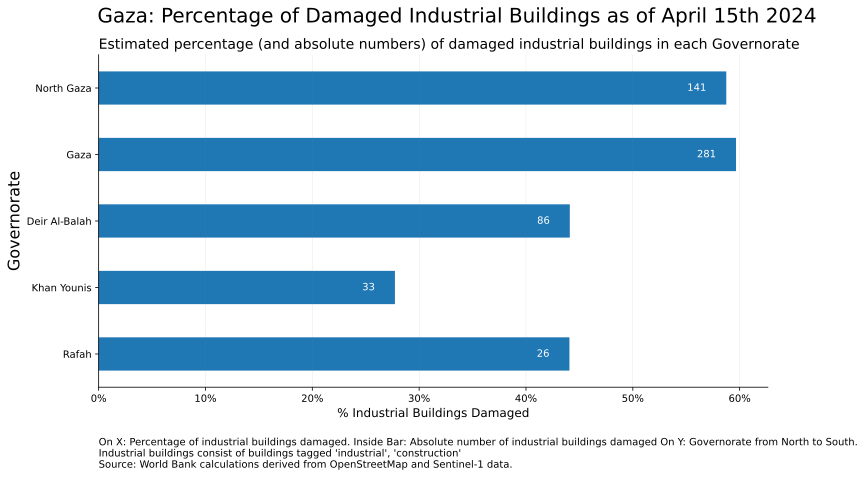

In [9]:
hbarplot(industry,
        "Gaza: Percentage of Damaged Industrial Buildings as of April 15th 2024",
        'damaged',
        'perc',
        "% Industrial Buildings Damaged",
        "Governorate",
        "Estimated percentage (and absolute numbers) of damaged industrial buildings in each Governorate",
        "On X: Percentage of industrial buildings damaged. Inside Bar: Absolute number of industrial buildings damaged On Y: Governorate from North to South.\nIndustrial buildings consist of buildings tagged 'industrial', 'construction'\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data."
)

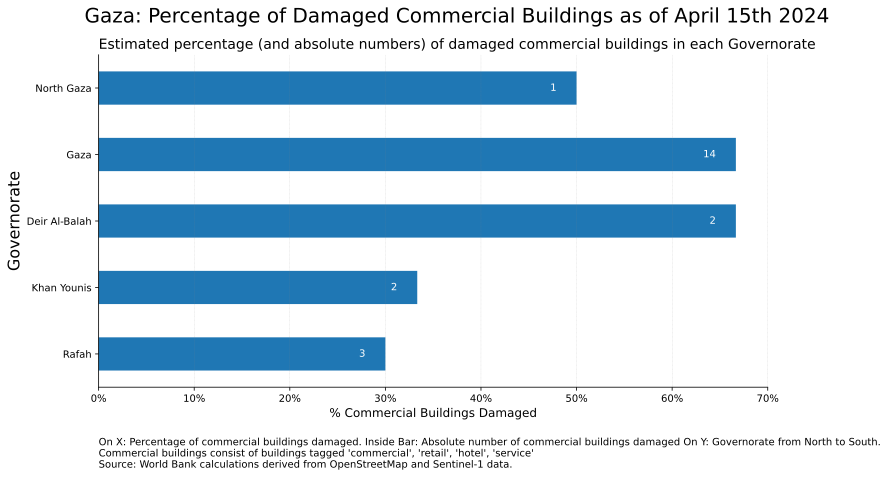

In [10]:
hbarplot(commerce,
        "Gaza: Percentage of Damaged Commercial Buildings as of April 15th 2024",
        'damaged',
        'perc',
        "% Commercial Buildings Damaged",
        "Governorate",
        "Estimated percentage (and absolute numbers) of damaged commercial buildings in each Governorate",
        "On X: Percentage of commercial buildings damaged. Inside Bar: Absolute number of commercial buildings damaged On Y: Governorate from North to South.\nCommercial buildings consist of buildings tagged 'commercial', 'retail', 'hotel', 'service'\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data."
)

### Observations and Limitations

* The number of buildings tagged as industrial and commercial on the OpenStreetMap database are few, this could explain the high percentage of damage seen in the North Gaza Governorate. 

## Percentage of Points of Interest Damaged

In [11]:
POI = geopandas.read_file('../../../data/damaged_buildings/damaged_pois_1_10Apr2024_2_5sigma.shp').to_crs("EPSG:4326")

POI = geopandas.sjoin(POI, GAZA)
POI["fclass"] = POI["fclass"].fillna("")

In [12]:
def get_poi_classification(fclass):
    if fclass in [
        "school",
        "kindergarten",
        "university",
        "college",
    ]:
        return "Education"
    if fclass in [
        "tower",
        "wastewater_plant",
        "water_tower",
        "telephone",
        "water_well",
        "drinking_water",
        "recycling",
    ]:
        return "Critical Infrastructure"
    if fclass in [
        "pharmacy",
        "dentist",
        "doctors",
        "hospital",
        "clinic",
        "nursing_home",
    ]:
        return "Health"
    if fclass in [
        "public_building",
        "police",
        "courthouse",
        "library",
        "monument",
        "post_office",
        "memorial",
        "community_centre",
        "town_hall",
        "museum",
        "arts_centre",
        "sports_centre",
        "tourist_info",
        "fire_station",
    ]:
        return "Public Amenities"

    elif fclass in [
        "clothes",
        "supermarket",
        "restaurant",
        "laundry",
        "cafe",
        "computer_shop",
        "convenience",
        "furniture_shop",
        "shoe_shop",
        "bakery",
        "hotel",
        "hairdresser",
        "fast_food",
        "bank",
        "viewpoint",
        "artwork",
        "picnic_site",
        "chalet",
        "caravan_site",
        "greengrocer",
        "beauty_shop",
        "car_dealership",
        "attraction",
        "pub",
        "waste_basket",
        "nightclub",
        "playground",
        "department_store",
        "outdoor_shop",
        "atm",
        "butcher",
        "car_rental",
        "doityourself",
        "guesthouse",
        "beverages",
        "theatre",
        "newsagent",
        "cinema",
        "mobile_phone_shop",
        "car_wash",
        "bookshop",
        "hostel",
        "sports_shop",
        "castle",
        "pitch",
        "car_sharing",
        "vending_machine",
        "food_court",
        "gift_shop",
        "camp_site",
        "veterinary",
        "post_box",
        "florist",
        "jeweller",
        "chemist",
        "motel",
        "alpine_hut",
        "mall",
        "kiosk",
        "bicycle_shop",
        "bench",
        "optician",
        "travel_agent",
        "biergarten",
        "toy_shop",
        "bar",
        "fountain",
        "archaeological",
        "shelter",
        "park",
        "stationery",
        "market_place",
        "zoo",
    ]:
        return "Places of Economic Activity"

In [13]:
POI["type"] = POI["fclass"].apply(get_poi_classification)

In [24]:
economy = get_percentage_damaged(POI[POI["type"] == "Places of Economic Activity"], 
                                 'ADM2_EN', '_upd10max', 0.5, sort_order)
critical_infrastructure = get_percentage_damaged(POI[POI["type"] == "Critical Infrastructure"], 
                                                 'ADM2_EN', '_upd10max', 0.5, sort_order)

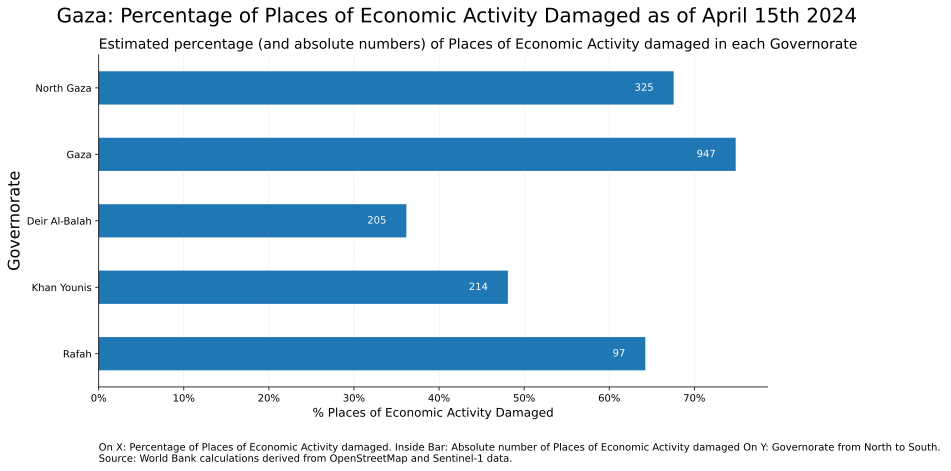

In [25]:
hbarplot(economy,
        "Gaza: Percentage of Places of Economic Activity Damaged as of April 15th 2024",
        'damaged',
        'perc',
        "% Places of Economic Activity Damaged",
        "Governorate",
        "Estimated percentage (and absolute numbers) of Places of Economic Activity damaged in each Governorate",
        "On X: Percentage of Places of Economic Activity damaged. Inside Bar: Absolute number of Places of Economic Activity damaged On Y: Governorate from North to South. \nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data."
    )

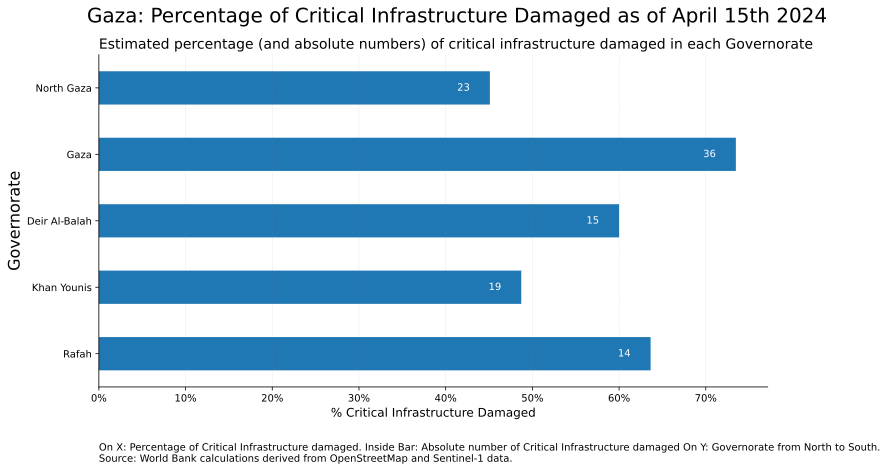

In [26]:
hbarplot(critical_infrastructure,
        "Gaza: Percentage of Critical Infrastructure Damaged as of April 15th 2024",
        'damaged',
        'perc',
        "% Critical Infrastructure Damaged",
        "Governorate",
        "Estimated percentage (and absolute numbers) of critical infrastructure damaged in each Governorate",
        "On X: Percentage of Critical Infrastructure damaged. Inside Bar: Absolute number of Critical Infrastructure damaged On Y: Governorate from North to South. \nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data."
    )

## Impact to Roads

In [38]:
ROADS = geopandas.read_file("../../../data/damaged_roads/damaged_roads_lines_10Apr2024_2_5sigma.shp").to_crs("EPSG:4326")
ROADS = geopandas.sjoin(ROADS, GAZA)

In [58]:
mapper = {
    "track": "Tracks",
    "unclassified": "Unclassified",
    "residential": "Other",
    "tertiary": "Tertiary",
    "service": "Other",
    "secondary": "Secondary",
    "track_grade3": "Tracks",
    "track_grade5": "Tracks",
    "trunk": "Other",
    "path": "Other",
    "track_grade4": "Tracks",
    "primary": "Primary",
    "secondary_link": "Secondary",
    "footway": "Other",
    "steps": "Other",
    "tertiary_link": "Tertiary",
    "trunk_link": "Other",
    "pedestrian": "Other",
    "primary_link": "Primary",
    "living_street": "Other",
    "unknown": "Unclassified",
    "track_grade1": "Tracks",
}
ROADS["type"] = ROADS["fclass"].replace(mapper)

In [59]:
primary_secondary_roads = get_percentage_damaged(ROADS[ROADS["type"].isin(["Primary", "Secondary"])], 
                                                'ADM2_EN', '_upd10max', 0.5, sort_order)

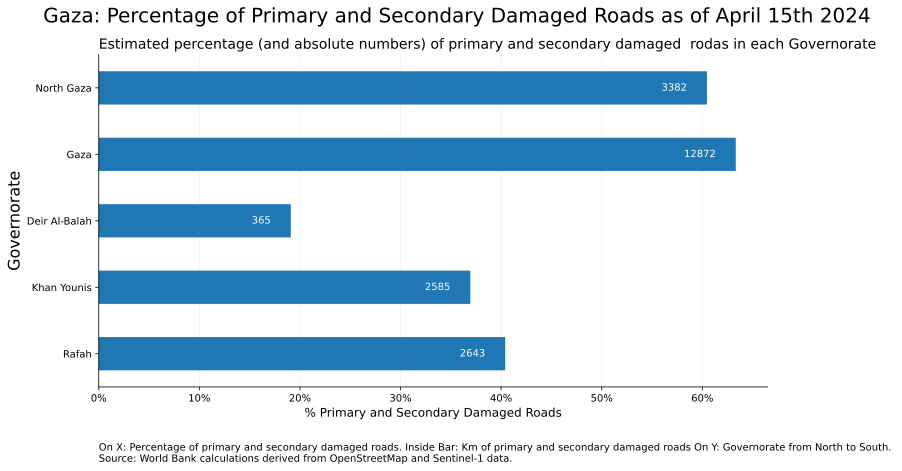

In [60]:
hbarplot(primary_secondary_roads,
        "Gaza: Percentage of Primary and Secondary Damaged Roads as of April 15th 2024",
        'damaged',
        'perc',
        "% Primary and Secondary Damaged Roads",
        "Governorate",
        "Estimated percentage (and absolute numbers) of primary and secondary damaged  rodas in each Governorate",
        "On X: Percentage of primary and secondary damaged roads. Inside Bar: Km of primary and secondary damaged roads On Y: Governorate from North to South. \nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data."
    )

## Overall Impact on Industry and Commerce

In [61]:
critical_infrastructure.rename(
    columns={
        "perc": "% Critical Infrastructure Damaged",
        "damaged": "Number of Points of Critical Infrastructure Damaged",
    },
    inplace=True,
)
economy.rename(
    columns={
        "damaged": "Number of Places of Economic Activity Damaged",
        "total": "economy_total",
        "perc": "% Places of Economic Activity Damaged",
    },
    inplace=True,
)
industry.rename(
    columns={
        "damaged": "Number of Industrial Buildings Damaged",
        "total": "industry_total",
        "perc": "% Industrial Buildings Damaged",
    },
    inplace=True,
)
commerce.rename(
    columns={
        "damaged": "Number of Commercial Buildings Damaged",
        "total": "commerce_total",
        "perc": "% Commercial Buildings Damaged",
    },
    inplace=True,
)
primary_secondary_roads.rename(
    columns={
        "damaged": "Primary and Secondary Damaged Roads (in km)",
        "perc": "% Primary and Secondary Roads Damaged",
    },
    inplace=True,
)

In [62]:
summary_stats = pd.concat([
    industry,
    commerce,
    economy,
    critical_infrastructure,
    primary_secondary_roads
], axis = 1
)

In [63]:
summary_stats.index.name = 'Governorate'

In [64]:
summary_stats[
    [
        "% Industrial Buildings Damaged",
        "% Commercial Buildings Damaged",
        "% Places of Economic Activity Damaged",
        "% Critical Infrastructure Damaged",
        '% Primary and Secondary Roads Damaged'
    ]
].style.background_gradient(cmap="viridis", axis=0).format("{:.0f}%")

In [66]:
summary_stats[
    [
        "Number of Industrial Buildings Damaged",
        "Number of Commercial Buildings Damaged",
        "Number of Places of Economic Activity Damaged",
        "Number of Points of Critical Infrastructure Damaged",
        'Primary and Secondary Damaged Roads (in km)'
    ]
].style.background_gradient(cmap="viridis", axis=0).format("{:.0f}")

## Observations

* The Governorate of Gaza has seen the highest impact for industry and commerce.
* North Gaza has the second highest amount of roads damaged, both in absolute figures and percentage values.